# News classification with topic models in gensim
News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

Our aim in this tutorial is to come up with some topic model which can come up with topics that can easily be interpreted by us. Such a topic model can be used to discover hidden structure in the corpus and can also be used to determine the membership of a news article into one of the topics.

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

Accompanying slides can be found [here](https://speakerdeck.com/dsquareindia/pycon-delhi-lightening).

### Requirements
In this tutorial we look at how different topic models can be easily created using [gensim](https://radimrehurek.com/gensim/).
Following are the dependencies for this tutorial:
    - Gensim Version >=0.13.1 would be preferred since we will be using topic coherence metrics extensively here.
    - matplotlib
    - Patterns library; Gensim uses this for lemmatization. ONLY FOR PYTHON 2.5+ - no support for Python 3 yet.
    - nltk.stopwords
    - pyLDAVis
We will be playing around with 4 different topic models here:
    - LSI (Latent Semantic Indexing)
    - HDP (Hierarchical Dirichlet Process)
    - LDA (Latent Dirichlet Allocation)
    - LDA (tweaked with topic coherence to find optimal number of topics) and
    - LDA as LSI with the help of topic coherence metrics
First we'll fit those topic models on our existing data then we'll compare each against the other and see how they rank in terms of human interpretability.

All can be found in gensim and can be easily used in a plug-and-play fashion. We will tinker with the LDA model using the newly added topic coherence metrics in gensim based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al and see how the resulting topic model compares with the exsisting ones.

In [ ]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

%matplotlib inline

In [2]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'

Analysing our corpus.
    - The first document talks about a bushfire that had occured in New South Wales.
    - The second talks about conflict between India and Pakistan in Kashmir.
    - The third talks about road accidents in the New South Wales area.
    - The fourth one talks about Argentina's economic and political crisis during that time.
    - The last one talks about the use of drugs by midwives in a Sydney hospital.
Our final topic model should be giving us keywords which we can easily interpret and make a small summary out of. Without this the topic model cannot be of much practical use.

In [3]:
with open(lee_train_file) as f:
    for n, l in enumerate(f):
        if n < 5:
            print([l])

['Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at t

In [4]:
def build_texts(fname):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    with open(fname) as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [5]:
train_texts = list(build_texts(lee_train_file))

In [6]:
len(train_texts)

300

### Preprocessing our data. Remember: Garbage In Garbage Out
                                        "NLP is 80% preprocessing."
                                                                -Lev Konstantinovskiy
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
1. Stopword removal using NLTK's english stopwords dataset.
2. Bigram collocation detection (frequently co-occuring tokens) using gensim's [Phrases](https://radimrehurek.com/gensim/models/phrases.html). This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
3. Lemmatization (using gensim's [`lemmatize`](https://radimrehurek.com/gensim/utils.html#gensim.utils.lemmatize)) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [7]:
bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection

In [8]:
bigram[['new', 'york', 'example']]

[u'new_york', u'example']

In [9]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

In [10]:
stops = set(stopwords.words('english'))  # nltk stopwords list

In [11]:
def process_texts(texts):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    return texts

In [12]:
try:
    train_texts = process_texts(train_texts)
    print(train_texts[5:6])
except ImportError:
    raise ValueError("SKIP: Install Pattern library to run functions using lemmatize")

[['afghani', 'asylum_seeker', 'australia', 'return', 'home', 'environment', 'government', 'application', 'kabul', 'foreign_affair', 'downer', 'process', 'threat', 'person', 'asylum', 'afghan', 'australia', 'matter', 'britain', 'country', 'europe', 'taliban', 'power', 'afghanistan', 'taliban', 'airlift', 'detainee', 'christmas', 'island', 'island', 'nauru', 'total', 'person', 'island', 'operation', 'aircraft', 'airlift', 'today', 'asylum_seeker', 'claim', 'visa', 'department', 'immigration', 'detainee', 'christmas', 'island', 'spokesman', 'decision']]


Finalising our dictionary and corpus

In [13]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

### Topic modeling with LSI
This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a `num_topics` parameter (set to 200 by default) to determine the number of latent dimensions after the SVD.

In [14]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [15]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  u'0.241*"person" + 0.202*"australia" + 0.201*"government" + 0.193*"afghanistan" + 0.182*"day" + 0.174*"attack" + 0.156*"force" + 0.155*"area" + 0.154*"man" + 0.147*"security"'),
 (1,
  u'-0.524*"fire" + -0.274*"sydney" + -0.269*"area" + -0.219*"firefighter" + -0.180*"wale" + -0.163*"wind" + 0.139*"israel" + 0.137*"attack" + -0.136*"line" + -0.126*"today"'),
 (2,
  u'0.332*"australia" + -0.320*"israel" + -0.242*"palestinian" + 0.205*"afghanistan" + -0.204*"fire" + -0.177*"attack" + -0.173*"sharon" + -0.128*"yasser_arafat" + 0.122*"company" + -0.119*"office"'),
 (3,
  u'-0.353*"afghanistan" + 0.300*"australia" + -0.236*"pakistan" + -0.222*"force" + -0.154*"afghan" + 0.152*"test" + 0.150*"company" + -0.146*"area" + 0.131*"union" + -0.115*"tora_bora"'),
 (4,
  u'-0.331*"union" + -0.327*"company" + 0.197*"test" + 0.193*"australia" + -0.191*"worker" + 0.190*"day" + -0.170*"qanta" + -0.150*"pakistan" + 0.136*"wicket" + -0.130*"commission"')]

In [16]:
lsitopics = lsimodel.show_topics(formatted=False)

### Topic modeling with [HDP](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf)
An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

In [17]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [18]:
hdpmodel.show_topics()

[u'topic 0: 0.004*airport + 0.003*taliban + 0.003*opposition + 0.002*night + 0.002*kandahar + 0.002*troop + 0.002*president_bush + 0.002*force + 0.002*expedition + 0.002*rest + 0.002*dissident + 0.002*gul + 0.002*lali + 0.002*person + 0.002*israel + 0.002*bombing + 0.002*firm + 0.002*out + 0.002*protester + 0.002*martyrdom',
 u'topic 1: 0.003*hare + 0.002*night + 0.002*ash + 0.002*area + 0.002*mouth + 0.002*benare + 0.002*today + 0.002*sect + 0.002*soul + 0.002*detail + 0.002*defiance + 0.002*harrison + 0.002*amalgamation + 0.002*portion + 0.002*administration + 0.002*scatter + 0.002*river + 0.002*rumsfeld + 0.002*morning + 0.002*diversity',
 u'topic 2: 0.003*government + 0.003*group + 0.002*call + 0.002*warning + 0.002*cow + 0.002*helicopter + 0.002*palestinian + 0.002*accomplishment + 0.002*china + 0.002*sabotage + 0.002*uncertainty + 0.002*manufacturing + 0.002*disease + 0.002*civilian + 0.002*japan + 0.002*sharon + 0.002*sheet + 0.002*coastguard + 0.002*israel + 0.002*case',
 u'top

In [19]:
hdptopics = hdpmodel.show_topics(formatted=False)

### Topic modeling using [LDA](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei. Let's choose 10 topics to initialize this.

In [20]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. pyLDAvis is based on [this](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [21]:
import pyLDAvis.gensim

In [22]:
pyLDAvis.enable_notebook()

In [23]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      20.828435        1       1 -0.030657 -0.013265
5      11.593699        1       2 -0.035344 -0.072300
3      10.206942        1       3  0.014996 -0.016466
1       9.907183        1       4 -0.075596  0.052259
4       8.787995        1       5 -0.004824 -0.049914
8       8.572946        1       6  0.021528  0.014594
2       8.283057        1       7  0.019516  0.016325
6       7.908072        1       8  0.106544  0.010289
7       7.533131        1       9 -0.011300  0.069902
9       6.378540        1      10 -0.004863 -0.011423, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
574   Default   51.000000         union   51.000000  30.0000  30.0000
2354  Default   62.000000          fire   62.000000  29.0000  29.0000
438   Default   21.000000         storm   21.000000  28.0000  28.0000
2457  Default   47.000000        sydney   47.000000  27.0000  27.0000
2735  Default   23.000000         metre   23.000000  26.0000  26.0000
1922  Default   60.000000       company   60.000000  25.0000  25.0000
2850  Default   14.000000         abuse   14.000000  24.0000  24.0000
157   Default   29.000000         india   29.000000  23.0000  23.0000
1020  Default   13.000000        market   13.000000  22.0000  22.0000
2060  Default   15.000000         event   15.000000  21.0000  21.0000
2464  Default  115.000000     australia  115.000000  20.0000  20.0000
1458  Default   38.000000      pakistan   38.000000  19.0000  19.0000
2160  Default    9.000000        hewitt    9.000000  18.0000  18.0000
1672  Default   16.000000          road   16.000000  17.0000  17.0000
1110  Default   68.000000           man   68.000000  16.0000  16.0000
1853  Default   19.000000         qanta   19.000000  15.0000  15.0000
2989  Default   66.000000        attack   66.000000  14.0000  14.0000
2924  Default    5.000000       product    5.000000  13.0000  13.0000
2195  Default    8.000000         virus    8.000000  12.0000  12.0000
589   Default   27.000000        worker   27.000000  11.0000  11.0000
2281  Default    8.000000       project    8.000000  10.0000  10.0000
379   Default   14.000000          tree   14.000000   9.0000   9.0000
194   Default   44.000000     president   44.000000   8.0000   8.0000
1346  Default   28.000000      per_cent   28.000000   7.0000   7.0000
1097  Default   22.000000       economy   22.000000   6.0000   6.0000
1201  Default   15.000000         space   15.000000   5.0000   5.0000
3382  Default   41.000000        leader   41.000000   4.0000   4.0000
949   Default   31.000000          team   31.000000   3.0000   3.0000
2688  Default   17.000000          race   17.000000   2.0000   2.0000
3461  Default   39.000000      official   39.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
2195  Topic10    2.620316         virus    8.933098   1.5258  -6.0049
1206  Topic10    1.803324      internet    5.473515   1.6419  -6.3785
1346  Topic10    5.036825      per_cent   28.823165   1.0078  -5.3514
2532  Topic10    2.982079       militia   13.061232   1.2752  -5.8756
2989  Topic10    7.324090        attack   66.913710   0.5400  -4.9770
1110  Topic10    6.925659           man   68.018217   0.4677  -5.0329
1996  Topic10    1.891299         trade    6.330132   1.5442  -6.3309
1922  Topic10    6.098465       company   60.361219   0.4599  -5.1601
574   Topic10    5.633899         union   51.751702   0.5346  -5.2394
2464  Topic10    8.480951     australia  115.848266   0.1378  -4.8304
2307  Topic10    5.314232  united_state   47.251614   0.5671  -5.2978
1608  Topic10    4.962166         world   44.962648   0.5482  -5.3663
347   Topic10    4.103457       service   32.075054   0.6960  -5.5563
3289  Topic10    2.953443        weapon   16.249984   1.0471  -5.8852
2422  Topic10    6.

In [24]:
ldatopics = ldamodel.show_topics(formatted=False)

### Finding out the optimal number of topics
__Introduction to topic coherence__:
<img src="https://rare-technologies.com/wp-content/uploads/2016/06/pipeline.png">
Topic coherence in essence measures the human interpretability of a topic model. Traditionally [perplexity has been used](http://qpleple.com/perplexity-to-evaluate-topic-models/) to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. Here's a short blog I wrote explaining topic coherence:
[What is topic coherence?](https://rare-technologies.com/what-is-topic-coherence/)

In [25]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

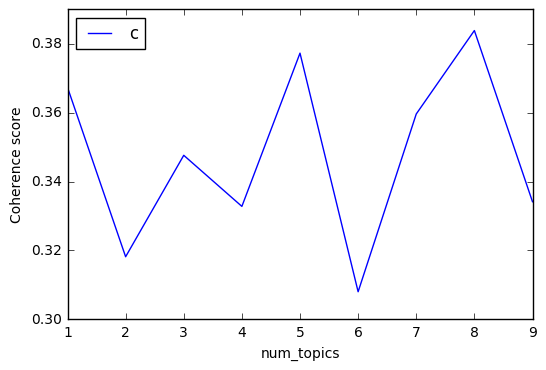

CPU times: user 28 s, sys: 81.6 ms, total: 28.1 s
Wall time: 28.1 s


In [26]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)

In [27]:
pyLDAvis.gensim.prepare(lmlist[2], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      38.538462        1       1 -0.019749  0.029392
0      37.201228        1       2 -0.016563 -0.031164
2      24.260310        1       3  0.036312  0.001771, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
2464  Default  114.000000     australia  114.000000  30.0000  30.0000
2354  Default   65.000000          fire   65.000000  29.0000  29.0000
2408  Default   41.000000     yesterday   41.000000  28.0000  28.0000
1608  Default   45.000000         world   45.000000  27.0000  27.0000
2904  Default   90.000000           day   90.000000  26.0000  26.0000
1553  Default   27.000000      director   27.000000  25.0000  25.0000
2160  Default    9.000000        hewitt    9.000000  24.0000  24.0000
1192  Default   62.000000          year   62.000000  23.0000  23.0000
2549  Default   20.000000        wicket   20.000000  22.0000  22.0000
851   Default   37.000000          test   37.000000  21.0000  21.0000
3060  Default   13.000000       disease   13.000000  20.0000  20.0000
1458  Default   39.000000      pakistan   39.000000  19.0000  19.0000
3044  Default   36.000000        centre   36.000000  18.0000  18.0000
3333  Default   96.000000    government   96.000000  17.0000  17.0000
2704  Default   38.000000         power   38.000000  16.0000  16.0000
194   Default   44.000000     president   44.000000  15.0000  15.0000
157   Default   29.000000         india   29.000000  14.0000  14.0000
593   Default   44.000000         child   44.000000  13.0000  13.0000
2111  Default   34.000000        number   34.000000  12.0000  12.0000
1844  Default   21.000000          rate   21.000000  11.0000  11.0000
2074  Default   23.000000         issue   23.000000  10.0000  10.0000
2028  Default   27.000000         party   27.000000   9.0000   9.0000
3121  Default    4.000000         brain    4.000000   8.0000   8.0000
3434  Default   21.000000   firefighter   21.000000   7.0000   7.0000
1533  Default   20.000000           pay   20.000000   6.0000   6.0000
325   Default    9.000000       refugee    9.000000   5.0000   5.0000
3329  Default   20.000000         match   20.000000   4.0000   4.0000
1462  Default   12.000000        cancer   12.000000   3.0000   3.0000
1201  Default   13.000000         space   13.000000   2.0000   2.0000
2580  Default   21.000000          line   21.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
194    Topic3   16.202196     president   44.082727   0.4154  -5.5189
2028   Topic3   11.316862         party   27.661159   0.5226  -5.8778
3333   Topic3   29.219522    government   96.932173   0.2172  -4.9292
2111   Topic3   13.201587        number   34.242171   0.4632  -5.7237
3329   Topic3    8.875448         match   20.273052   0.5903  -6.1208
2074   Topic3    9.899894         issue   23.542890   0.5500  -6.0116
1192   Topic3   20.291253          year   62.996134   0.2834  -5.2939
3364   Topic3    5.662165        growth   11.278749   0.7272  -6.5703
3044   Topic3   13.129152        centre   36.037461   0.4066  -5.7292
949    Topic3   12.060000          team   32.671015   0.4197  -5.8142
1110   Topic3   20.479155           man   69.023723   0.2013  -5.2847
884    Topic3   18.054602          time   61.628349   0.1886  -5.4107
3087   Topic3   11.359110         staff   31.864387   0.3849  -5.8741
2422   Topic3   26.413153        person  125.028630  -0.1384  -5.0302
2070   Topic3    7.135271        health   16.218057   0.5953  -6.3390
851    Topic3   12.044264          test   37.583198   0.2784  -5.8155
2735   Topic3    9.384365         metre   25.307727   0.4243  -6.0650
2447   Topic3    6.381616           cup   13.772271   0.6471  -6.4507
1140   Topic3   14.741743         group   56.896837   0.0658  -5.6134
1931   Topic3   13.104328          hour   46.95

In [28]:
lmtopics = lmlist[5].show_topics(formatted=False)

### LDA as LSI

One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. Let us see if we can dig out the best topics from the best LDA model we can produce. The function below can be used to control the quality of the LDA model we produce.

In [29]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [30]:
%%time
lm, top_topics = ret_top_model()

CPU times: user 3min 49s, sys: 3.5 s, total: 3min 52s
Wall time: 2min 56s


In [31]:
print(top_topics[:5])

[(46, 0.98993831353039874), (53, 0.91150179907291595), (71, 0.90302748070962713), (70, 0.90178681005725581), (40, 0.85458736392159851)]


### Inference
We can clearly see below that the first topic is about __cinema__, second is about __email malware__, third is about the land which was given back to the __Larrakia aboriginal community of Australia__ in 2000. Then there's one about __Australian cricket__. LDA as LSI has worked wonderfully in finding out the best topics from within LDA.

In [32]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[(u'actor', 0.025946022624634402),
  (u'picture', 0.018433326607109113),
  (u'nomination', 0.017326081553327294),
  (u'comedy', 0.017326081553327294),
  (u'globe', 0.017326081553327294),
  (u'award', 0.017326081553327294),
  (u'actress', 0.017326081553327294),
  (u'film', 0.01732608155332729),
  (u'song', 0.0087061404820201853),
  (u'score', 0.0087061404820201853)],
 [(u'metre', 0.029678101574220662),
  (u'event', 0.028320272858576672),
  (u'race', 0.013907766493141006),
  (u'kieren', 0.012937355331713581),
  (u'water', 0.012607253556509117),
  (u'nail', 0.011077812729010461),
  (u'winner', 0.010447958770864763),
  (u'swimmer', 0.010234636770640196),
  (u'hass', 0.0099297904547094272),
  (u'ray', 0.0099133587839137071)],
 [(u'market', 0.018832918532041523),
  (u'rate', 0.011291139970440223),
  (u'account', 0.010693490816298605),
  (u'area', 0.010208016102526576),
  (u'growth', 0.0098463718778851027),
  (u'per_cent', 0.0089038896231044551),
  (u'sector', 0.0088686521526868435),
  (u'ba

In [33]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Evaluating all the topic models
Any topic model which can come up with topic terms can be plugged into the coherence pipeline. You can even plug in an [NMF topic model](http://derekgreene.com/nmf-topic/) created with scikit-learn.

In [34]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [35]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [36]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

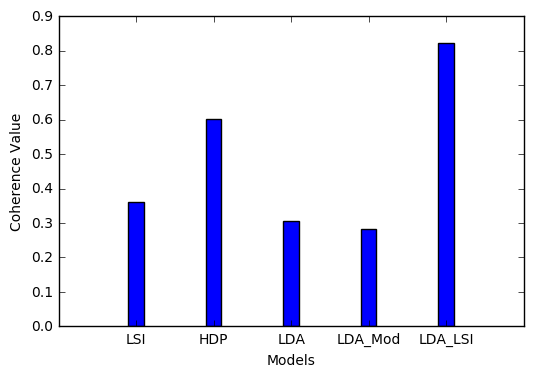

In [37]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

### Customizing the topic coherence measure
Till now we only used the `c_v` coherence measure. There are others such as `u_mass`, `c_uci`, `c_npmi`. All of these calculate coherence in a different way. `c_v` is found to be most in line with human ratings but can be much slower than `u_mass` since it uses a sliding window over the texts.

### Making your own coherence measure
Let's modify `c_uci` to use `s_one_pre` instead of `s_one_one` segmentation

In [38]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from collections import namedtuple

In [39]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [40]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model:

In [41]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

__Step 1__: Segmentation

In [42]:
# Perform segmentation
segmented_topics = measure.seg(topics)

__Step 2__: Probability estimation

In [43]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=train_texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

__Step 3__: Confirmation Measure

In [44]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

__Step 4__: Aggregation

In [45]:
print(measure.aggr(confirmed_measures))

-11.255475409


# How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.